# 📈 Price Optimization & Risk Analysis Project

## 1. Business Problem (โจทย์ทางธุรกิจ)
การตั้งราคาสินค้า (Pricing Strategy) คือหัวใจสำคัญของกำไร ธุรกิจมักเผชิญกับความท้าทาย:
- **ตั้งราคาต่ำไป:** ขายดีแต่กำไรหด (Low Margin)
- **ตั้งราคาสูงไป:** กำไรต่อชิ้นสูง แต่ไม่มีคนซื้อ (Low Volume)
- **ความไม่แน่นอน:** พฤติกรรมลูกค้าไม่ได้เป็นเส้นตรงเสมอไป ในวันที่เศรษฐกิจแย่ ลูกค้าอาจจะ Sensitive กับราคามาก (High Elasticity) แต่ในวันที่ดี อาจจะยอมจ่ายแพงได้

## 2. Solution Approach (แนวทางการแก้ปัญหา)
โปรเจกต์นี้จะใช้ **Data-Driven Approach** เพื่อหาราคาที่เหมาะสมที่สุด (Optimal Price) โดยคำนึงถึงความเสี่ยง:
1.  **Synthetic Data Generation:** จำลองข้อมูลยอดขายอิงตามหลักเศรษฐศาสตร์ (Demand Curve)
2.  **Demand Modeling:** ใช้ **Quantile Regression** เทียบกับ **OLS** เพื่อสร้างโมเดลความต้องการซื้อในสถานการณ์ต่างๆ (Best case / Worst case)
3.  **Revenue Optimization:** คำนวณหาราคาที่สร้างรายได้สูงสุด (Max Revenue) ภายใต้ความเสี่ยงที่ยอมรับได้

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.optimize import minimize
from IPython.display import Markdown, display

# Setting styles
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 3. Data Simulation (การจำลองข้อมูล)
สร้างข้อมูลจำลองประวัติการขายสินค้า โดยมีความสัมพันธ์ดังนี้:
$$ Demand = \text{Intercept} - \text{Slope} \times Price + \text{Noise} $$

- **Elasticity:** ราคายิ่งสูง ความต้องการยิ่งลดลง
- **Heteroscedasticity:** ที่ราคาต่ำ ความผันผวนของความต้องการจะสูง (Data spread กว้างกว่า)

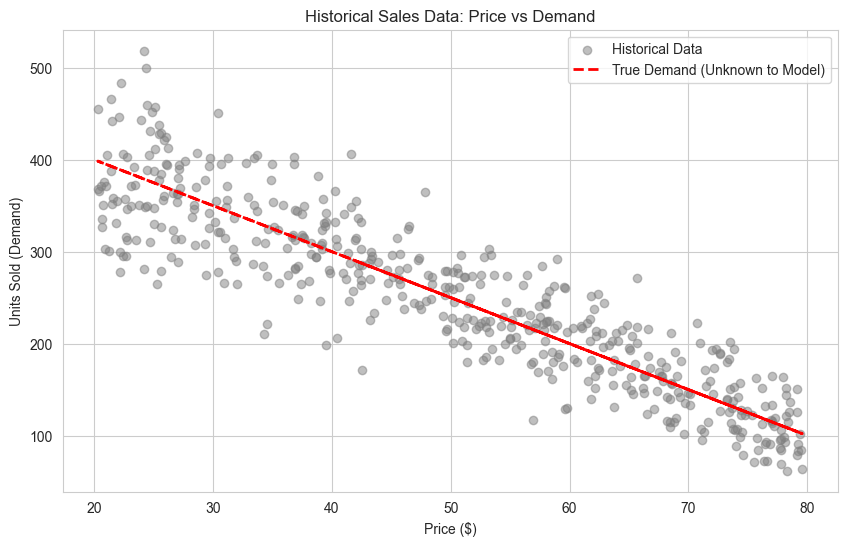

In [2]:
np.random.seed(42)
n_samples = 500

# 1. สร้างช่วงราคาที่เคยขาย (Price Range $20 - $80)
prices = np.random.uniform(20, 80, n_samples)

# 2. กำหนดพฤติกรรม Demand แท้จริง (True Demand Curve)
# Demand = 500 - 5 * Price
true_intercept = 500
true_slope = 5
base_demand = true_intercept - true_slope * prices

# 3. ใส่ Noise (ความผันผวนของตลาด)
# ยิ่งราคาถูก พฤติกรรมคนยิ่งหลากหลาย (Variance สูง)
noise_scale = 15 + 0.5 * (100 - prices)
noise = np.random.normal(0, noise_scale, n_samples)

demand = base_demand + noise
demand = np.maximum(0, demand)  # Demand ติดลบไม่ได้

# สร้าง DataFrame
df = pd.DataFrame({'Price': prices, 'Demand': demand})

# Visualize Data
plt.figure(figsize=(10, 6))
plt.scatter(df['Price'], df['Demand'], alpha=0.5, color='gray', label='Historical Data')
plt.plot(df['Price'], base_demand, color='red', linewidth=2, linestyle='--', label='True Demand (Unknown to Model)')
plt.xlabel('Price ($)')
plt.ylabel('Units Sold (Demand)')
plt.title('Historical Sales Data: Price vs Demand')
plt.legend()
plt.show()

## 4. Modeling: Demand Estimation
เราจะสร้างโมเดล 3 แบบเพื่อประเมิน Demand:
1.  **OLS (Ordinary Least Squares):** ทำนายค่าเฉลี่ย (Mean) -> เหมาะสำหรับสถานการณ์ปกติ
2.  **Quantile 0.1 (Conservative):** ทำนายกรณีตลาดแย่ (Worst-case scenario) -> สำหรับหลีกเลี่ยงความเสี่ยง
3.  **Quantile 0.9 (Aggressive):** ทำนายกรณีตลาดดี (Best-case scenario) -> สำหรับฉวยโอกาสทำกำไรสูงสุด

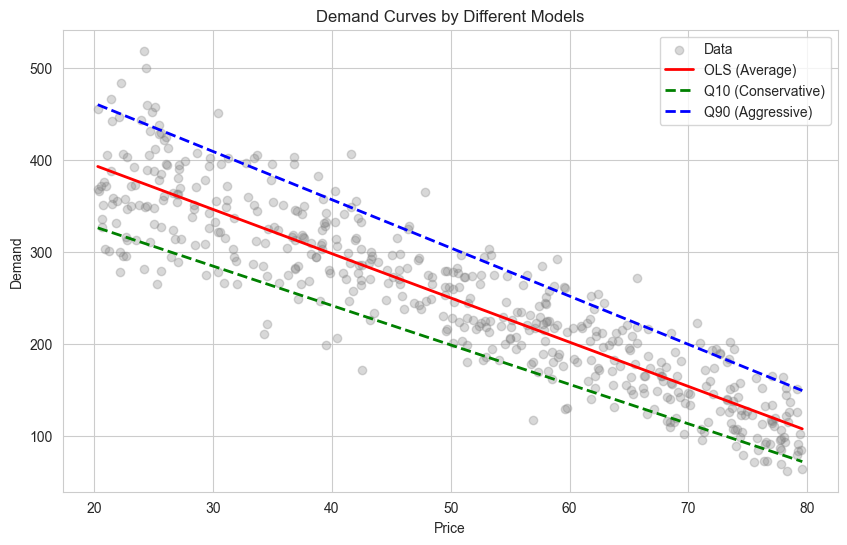

In [3]:
# Fit Models
model_ols = smf.ols('Demand ~ Price', df).fit()
model_q10 = smf.quantreg('Demand ~ Price', df).fit(q=0.1)
model_q50 = smf.quantreg('Demand ~ Price', df).fit(q=0.5)
model_q90 = smf.quantreg('Demand ~ Price', df).fit(q=0.9)

# Extract Coefficients (Intercept & Slope)
params = {
    'OLS (Mean)': model_ols.params,
    'Q10 (Risk)': model_q10.params,
    'Q50 (Median)': model_q50.params,
    'Q90 (Optimistic)': model_q90.params
}

# Create Prediction Lines for Visualization
x_range = pd.DataFrame({'Price': np.linspace(df['Price'].min(), df['Price'].max(), 100)})

plt.figure(figsize=(10, 6))
plt.scatter(df['Price'], df['Demand'], alpha=0.3, color='gray', label='Data')

# Plot Regression Lines
plt.plot(x_range, model_ols.predict(x_range), 'r-', linewidth=2, label='OLS (Average)')
plt.plot(x_range, model_q10.predict(x_range), 'g--', linewidth=2, label='Q10 (Conservative)')
plt.plot(x_range, model_q90.predict(x_range), 'b--', linewidth=2, label='Q90 (Aggressive)')

plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Demand Curves by Different Models')
plt.legend()
plt.show()

## 5. Revenue Optimization (การหาจุดราคาที่เหมาะสม)
Goal: Find $P$ that maximizes $Revenue(P) = P \times Demand(P)$

เราจะใช้ `scipy.optimize` หาจุดสูงสุดของกราฟรายได้สำหรับแต่ละโมเดล
- **Conservative Strategy (Q10):** ตั้งราคาโดยสมมติว่าลูกค้าจะซื้อน้อย (เซฟๆ)
- **Aggressive Strategy (Q90):** ตั้งราคาโดยสมมติว่าลูกค้าจะซื้อเยอะ (มั่นใจ)

In [4]:
def obj_revenue(price, intercept, slope):
    # Revenue = Price * Demand
    # Demand = Intercept + Slope * Price
    demand = intercept + slope * price
    if demand < 0: return 0
    return -(price * demand)  # Negative because 'minimize' function looks for minimum

results = []

for name, param in params.items():
    intercept = param['Intercept']
    slope = param['Price']
    
    # Find optimal price using Optimization
    # Starting guess = 50
    opt_res = minimize(obj_revenue, x0=[50], args=(intercept, slope), bounds=[(10, 100)])
    
    best_price = opt_res.x[0]
    max_rev = -opt_res.fun
    
    results.append({
        'Model': name,
        'Optimal_Price': best_price,
        'Max_Revenue': max_rev,
        'Intercept': intercept,
        'Slope': slope
    })

res_df = pd.DataFrame(results)
res_df

,Model,Optimal_Price,Max_Revenue,Intercept,Slope
0,OLS (Mean),50.942093,12489.617357,490.345680,-4.812775
1,Q10 (Risk),48.155004,9943.113669,412.962819,-4.287849
2,Q50 (Median),50.301732,12446.841288,494.887210,-4.919187
3,Q90 (Optimistic),53.988005,15287.093623,566.314424,-5.244817


## 6. Final Visualization: Revenue Curves
เปรียบเทียบกราฟรายได้ (Revenue Curve) ของแต่ละกลยุทธ์ เพื่อให้เห็น "Zone of Optimal Price"

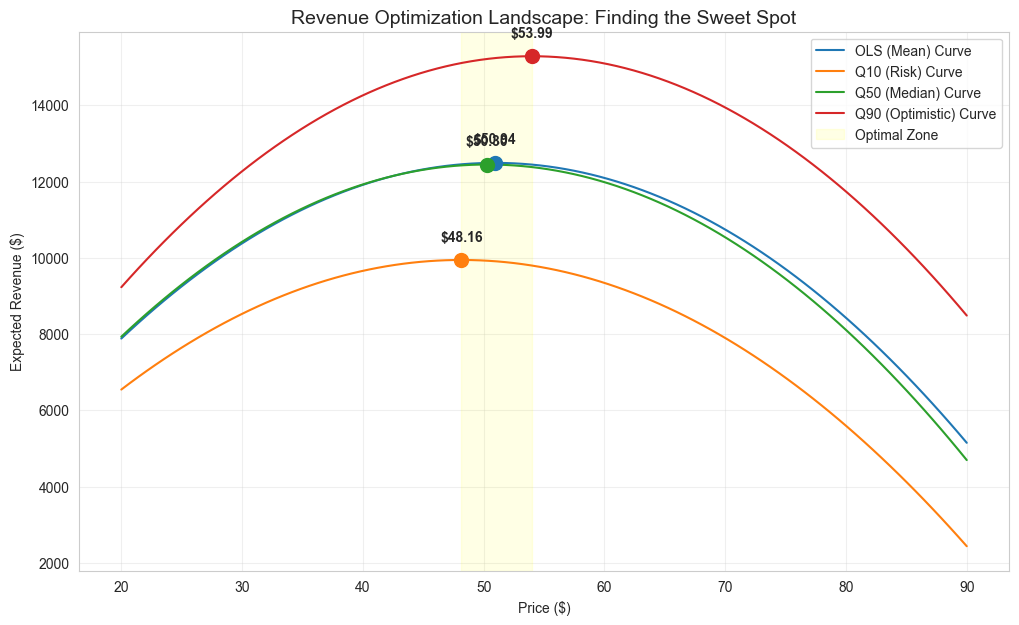

In [5]:
plt.figure(figsize=(12, 7))

price_sim = np.linspace(20, 90, 100)

for i, row in res_df.iterrows():
    # Calculate revenue curve for this model
    demands = row['Intercept'] + row['Slope'] * price_sim
    demands = np.maximum(0, demands)
    revenues = price_sim * demands
    
    # Plot curve
    plt.plot(price_sim, revenues, label=f"{row['Model']} Curve")
    
    # Mark optimal point
    plt.scatter([row['Optimal_Price']], [row['Max_Revenue']], s=100, zorder=5)
    plt.annotate(f"${row['Optimal_Price']:.2f}", 
                 (row['Optimal_Price'], row['Max_Revenue'] + 500), 
                 ha='center', fontweight='bold')

plt.axvspan(res_df.loc[1, 'Optimal_Price'], res_df.loc[3, 'Optimal_Price'], color='yellow', alpha=0.1, label='Optimal Zone')
plt.title('Revenue Optimization Landscape: Finding the Sweet Spot', fontsize=14)
plt.xlabel('Price ($)')
plt.ylabel('Expected Revenue ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
# Business Conclusion (สรุปผลทางธุรกิจ)
txt = """
## 7. Business Conclusion (สรุปผลทางธุรกิจ)

จากการวิเคราะห์ เราค้นพบ **"Optimal Zone"** ของราคา:

1.  **ราคาแนะนำมาตรฐาน (Base Case - OLS):**
    - ควรตั้งราคาที่ประมาณ **${:.2f}** ซึ่งคาดว่าจะทำรายได้สูงสุดในภาวะปกติ

2.  **Safety Net (Conservative Case - Q10):**
    - ถ้ากังวลเรื่องยอดขายตกต่ำ หรือต้องการระบายสินค้า (Clearance) ควรลดราคาลงมาที่ **${:.2f}** เพื่อรักษายอดขาย (Volume) ให้พยุงรายได้ไว้

3.  **Profit Maximization (Aggressive Case - Q90):**
    - หากสินค้าเป็นที่นิยม หรือเป็นช่วงเทศกาล (High Demand) สามารถขยับราคาขึ้นไปได้ถึง **${:.2f}** เพื่อกอบโกยกำไรสูงสุด

**ข้อเสนอแนะ:** ไม่ควรตั้งราคาเดียวตลอดไป (Dynamic Pricing) แต่ควรปรับตามสัญญาณตลาด โดยวิ่งอยู่ในกรอบราคานี้
""".format(
    res_df.loc[0, 'Optimal_Price'],
    res_df.loc[1, 'Optimal_Price'],
    res_df.loc[3, 'Optimal_Price']
)

display(Markdown(txt))


## 7. Business Conclusion (สรุปผลทางธุรกิจ)

จากการวิเคราะห์ เราค้นพบ **"Optimal Zone"** ของราคา:

1.  **ราคาแนะนำมาตรฐาน (Base Case - OLS):**
    - ควรตั้งราคาที่ประมาณ **$50.94** ซึ่งคาดว่าจะทำรายได้สูงสุดในภาวะปกติ

2.  **Safety Net (Conservative Case - Q10):**
    - ถ้ากังวลเรื่องยอดขายตกต่ำ หรือต้องการระบายสินค้า (Clearance) ควรลดราคาลงมาที่ **$48.16** เพื่อรักษายอดขาย (Volume) ให้พยุงรายได้ไว้

3.  **Profit Maximization (Aggressive Case - Q90):**
    - หากสินค้าเป็นที่นิยม หรือเป็นช่วงเทศกาล (High Demand) สามารถขยับราคาขึ้นไปได้ถึง **$53.99** เพื่อกอบโกยกำไรสูงสุด

**ข้อเสนอแนะ:** ไม่ควรตั้งราคาเดียวตลอดไป (Dynamic Pricing) แต่ควรปรับตามสัญญาณตลาด โดยวิ่งอยู่ในกรอบราคานี้
